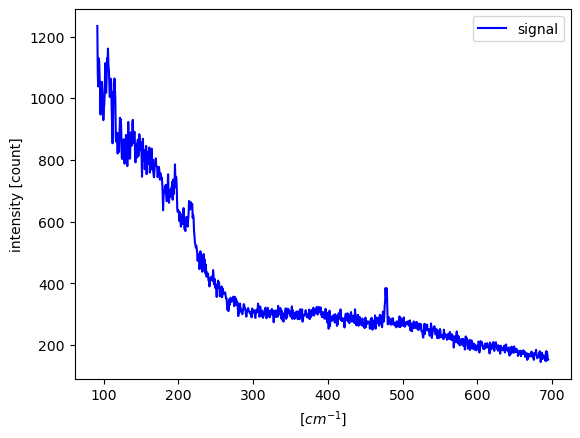

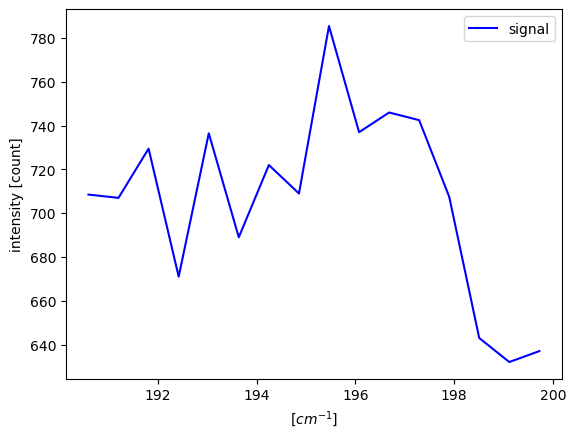

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 1200.

In [5]:
import re
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
import os
from scipy.special import voigt_profile

#voigt
def my_voigt(x, a, b, A, x_0, sigma, gamma):
    return a + b*x + A*voigt_profile(x-x_0, sigma, gamma)

#voigt 2
def my_voigt2(x, a, A, x_0, sigma, gamma):
    return a + A*voigt_profile(x-x_0, np.abs(sigma), np.abs(gamma))


# DATA -----------------------------------------------------------------------------------------------------------------------------------

nomeFile = "ASnGe_5o9_on_InSb_60s_3acc_20x_100pc_m150.txt" 



domanda=input('\n uagliù, che campione stai analizzando? a-SnGe % Ge = 0 (0), a-SnGe % Ge = 3.95 (1) o a-SnGe % Ge = 5.9 (2) ? ')


if (int(domanda)==0):
    xGe = 0
    xGe_o = '0o0'
    campione = '$\\alpha$-$SnGe$'
elif(int(domanda)==1):
    xGe = 3.95
    xGe_o = '3o95'
    campione = '$\\alpha$-$Sn_{1-0.0395}Ge_{0.0395}$'
else:
    xGe = 5.9
    xGe_o = '5o9'
    campione = '$\\alpha$-$Sn_{1-0.059}Ge_{0.059}$'


domanda=input('\n uagliù, vuoi vedere il picco Sn-Sn (0) o Sn-Ge (1)? ')

if (int(domanda)==0):
    picco = 'Sn-Sn'
    guess_x0 = 195
elif(int(domanda)==1):
    picco = 'Sn-Ge'
    guess_x0 = 215

T = input('\n uagliù, a che temperatura siamo? (scrivi - se minore di zero grazie) ')
    


w, I = np.loadtxt(nomeFile,usecols=(0, 1), unpack=True)

plt.plot(w,I,color='blue', label='signal')
#plt.title()
plt.xlabel('$[cm^{-1}]$')
plt.ylabel('intensity [count]')
plt.legend()
plt.show()

wMin = input(" \n lambda minima: ")
wMax = input("\n lambda massima: ")

def findIndex(valore, array):
    n = 0
    for el in array:
        if int(el) == int(valore):
            return n
        else:
            n += 1

nMin = findIndex(wMin, w)
nMax = findIndex(wMax, w)

W = w
II = I

w=w[nMin:nMax]
I=I[nMin:nMax]
dI = np.sqrt(I)

err_strum = np.abs(w[1]-w[2])/np.sqrt(12)

plt.plot(w, I, color='blue', label='signal')
plt.xlabel('$[cm^{-1}]$')
plt.ylabel('intensity [count]')
plt.legend()
plt.show()


# FIT -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# voigt 2
# def my_voigt2(x, a, A, x_0, sigma, gamma):
#     return a + A*voigt_profile(x-x_0, sigma, gamma)


p0 = [min(I), max(I), guess_x0, 2, 2]
(args, var) = curve_fit(my_voigt2, w, I, p0 = p0, sigma=dI)

x0 = args[2]
sigma1 = args[3]
gamma = args[4]

dx0 = np.sqrt(var[2,2])
dsigma1 = np.sqrt(var[3,3])
dgamma = np.sqrt(var[4,4])


f_g = 2.355*sigma1
f_l = 2*gamma 
FWHM = 0.5346*f_l + np.sqrt(0.2166*f_l**2 + f_g**2)



fig = plt.figure(figsize=(8, 6))  
plt.errorbar(W[nMin-20:nMax+20], II[nMin-20:nMax+20], marker='', linestyle='-', linewidth=2, color='blue', label = 'signal')
t = np.linspace(np.min(W[nMin-20:nMax+20]), np.max(W[nMin-20:nMax+20]), 10000)
plt.plot(t, my_voigt2(t, *args), linestyle="--", color="red", label="Voigt fit, $x_0 = $"+str("{:.2f}".format(args[2]))+" $cm^{-1}$, $\sigma$ = "+str("{:.2f}".format(args[3]))+" $cm^{-1}$, $\gamma$ = "+str("{:.2f}".format(args[4]))+" $cm^{-1}$")
#plt.plot(t, gauss_retta(t, args[0], args[1], args[2], args[3], args[4]), linestyle="--", color="orange", label="gauss", alpha=0.5)
#plt.plot(t, lorentz_retta(t, args[0], args[1], args[2], args[3], args[5]), linestyle="--", color="brown", label="lorentz", alpha=0.5)
plt.axvline(x = x0, linestyle="--", color="black", alpha=0.5)

plt.title(" "+campione+", "+picco+" peak, $T = $"+T+"$^{\circ}C$")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlabel('$[cm^{-1}]$')
plt.ylabel('intensity [count]')
plt.legend(loc="lower center")
plt.show()




domanda_err = input('\n uagliù, il picco è BEN visibile (0) oppure FA SCHIFO (1) ? ')

if (int(domanda_err)==0):
    if (dx0>err_strum):
        err_x0 = dx0
    elif(dx0<err_strum):
        err_x0 = err_strum

elif(int(domanda_err)==1):
    err_x0 = FWHM



# SAVE --------------------------------------------------------------------------------------------------------------------------------------------------------------------------

domanda_dati=input('\n uagliù, vuoi salvare i dati (0) o no (1)? ')

if(int(domanda_dati)==0):

    t = str(T)
    fig.savefig(f"fit_aSnGe_{xGe_o}_{picco}_{t}.png", dpi=300)  # Salva ancora possibile

    linea_iniziale='T \t x0 \t \t dx0 \t \t err_x0 \t \t sigma \t \t dsigma \t \t gamma \t \t dgamma \t \t FWHM \n'
    nome=  f'dati_con_fit_v2_aSnGe_{xGe_o}_{picco}.txt'
    # Controlla se il file esiste
    if not os.path.exists(nome):
        # Se non esiste, crealo e aggiungi la linea iniziale
        with open(nome, "w") as output_file:
            output_file.write(linea_iniziale)
    with open (nome, 'a') as output_file :
        output_file.write ( str(T) + '\t' + str(x0) + '\t' + str(dx0) + '\t' + str(err_x0) + '\t' + str(sigma1) + '\t' +  str(dsigma1) + '\t' + str(gamma) + '\t' +  str(dgamma) + '\t' + str(FWHM) + '\n')

else:
    exit()